This notebook is an example of how training works using ABC-SMC (Approximate Bayesian Computation with Sequential Monte-Carlo). Training this model can only be done in Google Cloud. For those interested by training this model, I can help with setting up a Google compute environment.


There are two files that can be modified in addition to this notebook:

In the same folder as the notebook:
- idiosyncratic_params.py
- model_prior_distributions.py

In the folder : COVID/Code/customize_blocks/parameter_function_generators.py


## Set up the notebook and load the BigQuery data

In [1]:
# Some packages to load.

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import _pickle as pkl
np.set_printoptions(suppress=True, precision = 5)
pd.set_option("display.max_rows", None, "display.max_columns", None)
import sys, csv, seaborn, time, datetime
sys.path.append('/home/roquero')
import COVID.Code as cvd
from COVID.Code.training_blocks import ModelSelectionABC
from COVID.Code.evaluating_blocks import SingleCountryEvaluatingModel, CrossValidateModel
from COVID.Code.epidemiology_blocks import ConstantParameter, VaryingParameter, EquationODE
import scipy.integrate as spint
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
from pyabc import (Distribution,
                   ABCSMC,
                   RV,
                   LocalTransition,
                   MedianEpsilon,
                   QuantileEpsilon,
                   ConstantEpsilon,
                   AdaptivePopulationSize,
                   SingleCoreSampler,
                   MulticoreParticleParallelSampler,
                   DaskDistributedSampler)
#!python /home/roquero/COVID/Code/setup_blocks/gce_load_data.py
ground_truth_global = pd.read_pickle("./.ground_truth_pd").groupby('country_region')

/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Model will be fitted with data from these countries:

In [2]:
# List of countries that will be used for training. (Canada, Australia and China not available)
# Need first to update their characteristics in idiosyncratic_params.py
list_countries = ['Spain', 'Italy']#,'United Kingdom']#, 'France']

## Ground truth curves:


These are the ground truth curves for the two countries in the list above.

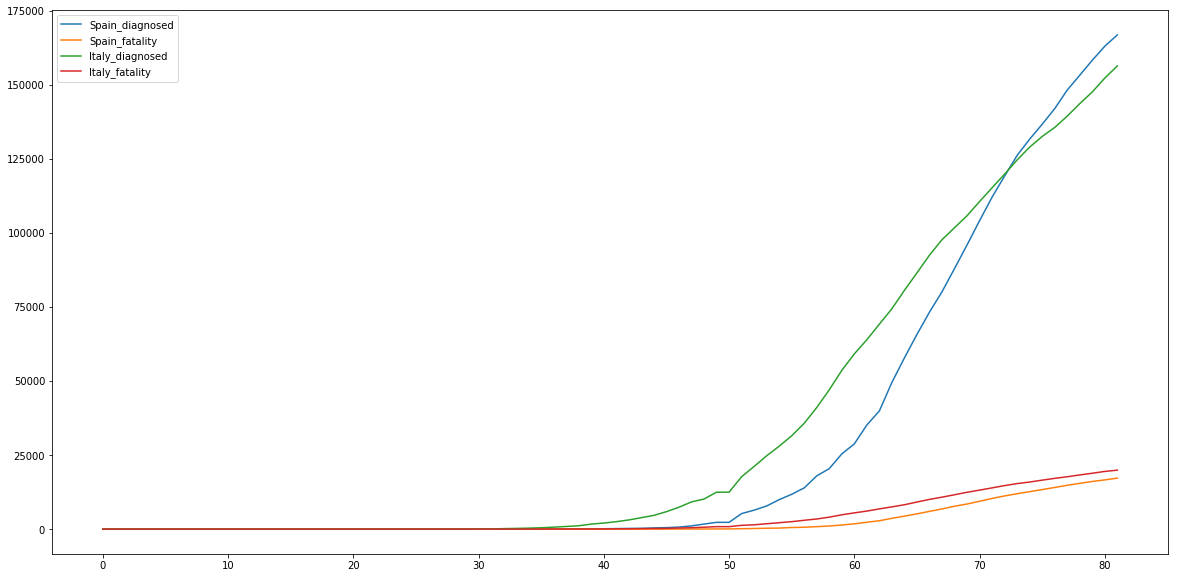

In [3]:
fig, ax = cvd.customize_blocks.plot_list_country_ground_truth(ground_truth_global, list_countries)
_ = plt.legend()
_ = plt.plot()

## Set up the model parameters.

We need to load 2 different types of parameters:
- those that are constant with respect to the ABC procedure. (fixed in file idiosyncratic_params.py)
- those that are "learnt" and sampled by the ABC procedure. (fixed in file model_prior_distributions_list.py)

In both cases, the parameters may be shared across countries, or not.

There are two files to modify: 
idiosyncratic_params.py (constant parameters)
model_prior_distributions_list.py (sampling parameters)

In [4]:
!python idiosyncratic_params.py
!python model_prior_distributions_list.py

We update the dictionary of sampled parameters with country specific parameters.

In [ ]:
def generate_country_params(list_countries):
    dict_params = {'F_ext_initial_date_{}'.format(name_country): RV("uniform", 0,40) for name_country in list_countries}
    dict_params.update({'tau_DiaS_initial_rate_{}'.format(name_country): RV("uniform", 0,10) for name_country in list_countries})

    dict_params.update({'tau_DiaA_initial_rate_{}'.format(name_country): RV("uniform", 0,10) for name_country in list_countries})

    dict_params.update({'rho_Fat_growth_rate_{}'.format(name_country): RV("uniform", 0,0.5) for name_country in list_countries})
    dict_params.update({'rho_Fat_growth_rate_sqrt_{}'.format(name_country): RV("uniform", 0,0.1) for name_country in list_countries})
    return dict_params

In [ ]:
with open('.pkl_idiosyncratic_params.pkl', 'rb') as f:
    dict_idiosyncratic_params_dict = pkl.load(f)
    dict_idiosyncratic_params_dict = {country: dict_idiosyncratic_params_dict[country] for country in list_countries}
    
with open('.pkl_model_prior_distributions.pkl', 'rb') as f:
    load_model_prior_distributions_list = pkl.load(f)['data']
    model_prior_distributions_list = []
    for model in load_model_prior_distributions_list:
        model.update_random_variables(**generate_country_params(list_countries))
        model_prior_distributions_list.append(model)

It is also possible to change the functional form of the time-varying parameters: 


COVID/Code/customize_blocks/parameter_function_generator.py

## Running the model:

Set the arguments for the model and dictionaries containing the data.

In [ ]:
ground_truth_dict = {country: cvd.customize_blocks.format_country_ground_truth(ground_truth_global, country) 
                     for country in list_countries}
idiosyncratic_params_dict = {country: dict_idiosyncratic_params_dict[country] for country in list_countries}

index_ground_truth_dict = {key:np.arange(4,8) for key in ground_truth_dict.keys()}

loss_function = cvd.customize_blocks.loss_real_world
factor_eps = 1
early_evaluation = False
checks = False
population_strategy = 100#AdaptivePopulationSize(100,mean_cv = 0.5, n_bootstrap=2, max_population_size=1000)
epsilon_strategy = MedianEpsilon(1000, median_multiplier = 1)
sampler = MulticoreParticleParallelSampler()#, DaskDistributedSampler()
transitions_list = [LocalTransition(k_fraction=1)]#, LocalTransition(k_fraction=.3)]

INFO:Sampler:Parallelizing the sampling on 12 cores.


Run the ABCSMC procedure.

In [ ]:
abc_procedure = ModelSelectionABC()
abc_procedure.set_country_model_ground_truth(ground_truth_dict = ground_truth_dict,
                                               index_ground_truth_dict = index_ground_truth_dict,
                                           idiosyncratic_params_dict = idiosyncratic_params_dict,
                                            n_days_dict = {},
                                           checks = checks)
abc_procedure.set_country_model_properties(loss_function = loss_function,
                                           factor_eps = factor_eps,
                                           early_evaluation = early_evaluation)
abc_procedure.set_abc_model_properties(population_strategy = population_strategy,
                                       epsilon_strategy = epsilon_strategy,
                                       sampler = sampler,
                                       transitions_list = transitions_list)
abc_procedure.add_parameter_prior_model(model_prior_distributions_list = model_prior_distributions_list)
db_path = "sqlite:///.presentation.db"


#### This block is for training the model

In [ ]:
#for item in np.arange(10):
#    abc = abc_procedure.generate_abc_class()
#    _ = abc.new(db_path)
#    print(item)
#    history = abc.run(minimum_epsilon=25, max_nr_populations=10)

#### This block is for loading a trained model.

In [ ]:
abc = abc_procedure.generate_abc_class()

history = abc.load(db_path, 6)
history.n_populations

9

## Evaluation / visualization of data

We now analyze the output of a trained model, that we loaded in the previous cell.

We start by plotting the mean and std of the sampled parameters (ie summary statistics of the posterior distribution)

In [ ]:
history.get_distribution()[0].mean()
history.get_distribution()[0].std()

name
F_ext_initial_date_Italy          11.989917
F_ext_initial_date_Spain          17.299084
F_ext_initial_rate                 0.102771
isolation_1_effect                 0.238859
isolation_2_effect                 0.268593
isolation_3_effect                 2.412443
lambda_A                           0.300496
rho_Fat_growth_rate                0.102179
rho_Fat_growth_rate_Italy          0.231508
rho_Fat_growth_rate_Spain          0.216752
rho_Fat_growth_rate_sqrt_Italy     0.045026
rho_Fat_growth_rate_sqrt_Spain     0.025968
rho_Fat_initial_rate               0.093476
rho_Hos                            0.040899
tau_ConA_initial_rate              0.277719
tau_ConS_initial_rate              0.232209
tau_DiaA_initial_rate              3.053860
tau_DiaA_initial_rate_Italy        3.330204
tau_DiaA_initial_rate_Spain        4.131832
tau_DiaS_growth_rate               2.838084
tau_DiaS_initial_rate              2.320417
tau_DiaS_initial_rate_Italy        4.540342
tau_DiaS_initial_rate_Spain

name
F_ext_initial_date_Italy          0.990059
F_ext_initial_date_Spain          0.848383
F_ext_initial_rate                0.014562
isolation_1_effect                0.031495
isolation_2_effect                0.033099
isolation_3_effect                0.090952
lambda_A                          0.006996
rho_Fat_growth_rate               0.010838
rho_Fat_growth_rate_Italy         0.036188
rho_Fat_growth_rate_Spain         0.021291
rho_Fat_growth_rate_sqrt_Italy    0.007752
rho_Fat_growth_rate_sqrt_Spain    0.005491
rho_Fat_initial_rate              0.016235
rho_Hos                           0.002286
tau_ConA_initial_rate             0.010435
tau_ConS_initial_rate             0.009879
tau_DiaA_initial_rate             0.258659
tau_DiaA_initial_rate_Italy       0.430216
tau_DiaA_initial_rate_Spain       0.323937
tau_DiaS_growth_rate              0.426147
tau_DiaS_initial_rate             0.354576
tau_DiaS_initial_rate_Italy       0.491878
tau_DiaS_initial_rate_Spain       0.541245
tau_Ho

## Start the analysis of the posterior distribution

Now based on the posterior samples of the parameters, we can generate new "synthetic" curves.

In [ ]:
country='Spain'

In [ ]:
n_days_simulation = None

visualization = SingleCountryEvaluatingModel(abc_procedure = abc_procedure,
                                             abc_history = history,
                                             n_days_simulation = n_days_simulation,
                                             name_country = country,
                                             index_population_iteration = None,
                                             checks = True)

### Run simulation based on one particle

In [ ]:
visualization.plot_posterior_individual(indices = [#'Susceptible',
                                                  #'Exposed',
                                                  #'Infectious Asymptomatic',
                                                  #'Infectious Symptomatic',
                                                  #'Diagnosed Asymptomatic',
                                                  #'Diagnosed_symptomatic',
                                                  #'Hospitalized',
                                                  'Fatality',
                                                  #'Recovered',
                                                  #'Total number of undiagnosed recoveries',
                                                  'Total number of diagnosed cases'],
                                       plot_ground_truth = True,
                                       t_max = None,
                                       particle_index=0)


Plot the curves. List of curve names: 'Susceptible','Exposed','Infectious Asymptomatic','Infectious Symptomatic','Diagnosed Asymptomatic','Diagnosed_symptomatic','Hospitalized','Fatality','Recovered','Total number of undiagnosed recoveries','Total number of diagnosed cases'.


### Run simulation by averaging posterior simulations

In [ ]:
visualization.plot_posterior_aggregate(indices = [#'Susceptible',
                                                  #'Exposed',
                                                  #'Infectious Asymptomatic',
                                                  #'Infectious Symptomatic',
                                                  #'Diagnosed Asymptomatic',
                                                  #'Diagnosed_symptomatic',
                                                  #'Hospitalized',
                                                  'Fatality',
                                                  #'Recovered',
                                                  #'Total number of undiagnosed recoveries',
                                                  'Total number of diagnosed cases'],
                                       plot_ground_truth = True,
                                       t_max = None)


## Run simulation based on modified individual particle

In [ ]:
pars_posterior = history.get_distribution()[0].iloc[0].to_dict()

# After loading a posterior sample, we can modify the value to generate a hypothetical curve.


pars_posterior['tau_ConA_initial_rate']=0.2763


constant_parameters_class0 = ConstantParameter(**pars_posterior, **dict_idiosyncratic_params_dict[country])
varying_parameters_class0 = VaryingParameter(**pars_posterior, **dict_idiosyncratic_params_dict[country])
equation0 = EquationODE(constant_parameters_class0, varying_parameters_class0)
y00 = np.zeros(10)
y00[0]=dict_idiosyncratic_params_dict[country]['population_size_{}'.format(country)]
t00=(0,85)

simulation_data = spint.solve_ivp(equation0.ODE_equation, t00, y00, t_eval = np.arange(t00[1]))

fig, ax = cvd.customize_blocks.plot_list_country_ground_truth(ground_truth_global, [country])
_ = plt.plot(simulation_data['t'], simulation_data['y'][6,:])
_ = plt.plot(simulation_data['t'], simulation_data['y'][9,:])
_ = plt.legend(['Fatality',
                'Total number of diagnosed cases.'
                    ])

## The generative model, without any training.

Based on the functional forms of the time-varying parameters, for different choices of models, one can fix these in advance and run a synthetic simulation.

In [ ]:
pars = {
'tau_Inc' :14,\
'tau_Rec' :21,\
'tau_Hos' :15,\
'lambda_A' :0.3,\
'rho_Hos' :0.05,\
'rho_Fat_initial_rate' :100,\
'rho_Fat_growth_rate' :0.01,\
'tau_DiaA_initial_rate' :0.01,\
'tau_DiaS_initial_rate' :0.01,\
'tau_DiaS_growth_rate' :0,\
'tau_ConA_initial_rate' :0.2,\
'tau_ConS_initial_rate' :0.2,\
'F_extA_initial_rate' :0.01,\
'F_extS_initial_rate' :0.01,\
'isolation_1_effect' :0.1,\
'isolation_2_effect' :0,\
'isolation_3_effect' :0,\
'F_ext_initial_date_Italy': 15,\
'F_ext_initial_rate': 0.1,\
'tau_DiaS_initial_rate_Italy':1 ,\
'tau_DiaA_initial_rate_Italy': 1,\
'rho_Fat_growth_rate_Italy':1 
}



In [ ]:
constant_parameters_class0 = ConstantParameter(**pars, **dict_idiosyncratic_params_dict['Italy'])
varying_parameters_class0 = VaryingParameter(**pars, **dict_idiosyncratic_params_dict['Italy'])
equation0 = EquationODE(constant_parameters_class0, varying_parameters_class0)

In [ ]:
y00 = np.zeros(10)
y00[0]=5000000  # Initial population

equation0._generate_varying_parameters(10, y00)
equation0._generate_matrix()
equation0.matrix

In [ ]:
# This is the number of days we want to generate data for.
t00=(0,200)

synthetic_data = spint.solve_ivp(equation0.ODE_equation, t00, y00, t_eval = np.arange(200))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
#_ = plt.plot(synthetic_data['t'], synthetic_data['y'][0,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][1,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][2,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][3,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][4,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][5,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][6,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][7,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][8,:])
_ = plt.plot(synthetic_data['t'], synthetic_data['y'][9,:])
_ = plt.legend([#'Susceptible',
                'Exposed',
                  'Infectious Asymptomatic',
                  'Infectious Symptomatic',
                  'Diagnosed',
                  'Hospitalized',
                  'Fatality',
                  'Recovered',
                  'Total number of undiagnosed recoveries',
                'Total number of diagnosed cases'
                    ])
#_ = plt.ylim((0,100000))